
## References
* [Probability Calibration curves example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py)
* [Calibrated Classifier Class in Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)
* [Why Model Calibration Matters and How](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)
* [Predicting Good Probabilities with Supervised Learning](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf)
* [Obtaining Calibrated Probabilities from Boosting](https://arxiv.org/pdf/1207.1403.pdf)
* [Classification: Prediction Bias](https://developers.google.com/machine-learning/crash-course/classification/prediction-bias)
* [Calibration by Andreas Muller](https://www.youtube.com/watch?v=w3OPq0V8fr8)
    * [Slides](https://amueller.github.io/COMS4995-s20/slides/aml-10-calibration-imbalanced-data/#2)


In [38]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (brier_score_loss,
                             precision_score, 
                             recall_score,
                             f1_score)

In [39]:
# Create dataset
X, y = datasets.make_classification(n_samples=100_000, n_features=20,
                                    n_informative=5, n_redundant=1,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

## What is probability calibration? What does it mean for a forecast to be well calibrated?

The goal of supervised machine learning models is to generate predictions on the outcomes of new data. Typically we care about the outcome of an event or class of an observation. For example, is the email a spam or not spam? Will it rain today or not? Is it a picture of a cat or not?. But occassionally we are also interested in the probability of an outcome of interest to either rank observations by their likelihood of occurrance or create some measure of confidence about the outcome of an event. 

Classification models can produce these scores as values ranging from zero to one. Because the scores is a fraction, they are often interpreted as probabilities.

It turns out that for some models this interpretation is incorrect. Although the scores satisfy the definition of a probability (a real number between 0 and 1 and the sum across all outcomes equals 1), it is possible that they do not represent the actual frequency of occurence of the classes. As such, the scores could over- or understate the likelihood that a given outcome will occur. To fix this, the scores must be calibrated.

What does it mean for a score to be well calibrated? Consider the question of whether it will rain or not. To say that a score is well calibrated means if out of all the times the model said that there was a 40 percent chance of rain, rain did actually fall 40 percent of the time [source: Google Blog]

More generally, out of all the records where P(Y==1|X) = 0.4 (or close to 0.4), do we actually see that around 40% of these records are positive classes.

### Note
* It is possible to have a well-calibrated but useless model
    * If 40% of the customers churned in the data, we can use the model P(Churn) = 0.4 for each customer
    * This model is perfectly calibrated: when it predicts 0.4 and 40% of our customers actually churned
    * But this model cannot explain the prediction: P(Churn|X) = P(Churn). It cannot rank the customers in our dataset by their probability of churning because it assigns the same probability to all customers.
    * Thus it is possible to have well-calibrated but useless models
* It is possible to have poorly calibrated but useful model
    * RF is a poorly calibrated but useful model: it can rank customers by their probability of churning but will underestimate probability of churn for predictions <50% and overestimate it for predictions >50% (See Muller lecture)
    * RF model also has a lower [Brier Score](https://en.wikipedia.org/wiki/Brier_score) even though it is miscalibrated ([see this](https://amueller.github.io/COMS4995-s20/slides/aml-10-calibration-imbalanced-data/#7))

## Why might we care about probability predictions over classification
* Any time you need to calculate expected values: Using the prediction as a score to rank which customers to target in marketing campaign, then no calibration is required. However, if the predictions will be used to compute say expected revenue, then the model's predicton should be calibrated
* Simplifies interaction of large systems that depend on model output from different sources: a downstream model may start generating unexpected predictions because an upstream model it depends on was updated with a new model that changes its output's distribution (because it was not calibrated). Here's a concrete example:

```
For example, let’s say you quantify the importance of an email using a  Pr(Important)  model. This is then an input to a  Pr(Spam)  model, and the  Pr(Spam)  model decides which emails get flagged as spam. Now the  Pr(Important)  model becomes miscalibrated and starts assigning too high of probabilities for emails being important. In this case, you can just change the threshold for  Pr(Important)  and the system seems to be back to normal. However, downstream your  Pr(Spam)  model just sees the shift and starts under-predicting spam because the upstream importance signal is telling it that they’re likely to be important. The numerical value of the signal became decoupled from the event it was measuring even as the ordinal value remained unchanged. And users may start receiving a lot more spam!
```[Source](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)

* For evaluating confidence in an outcome: for example, you may be be more interested in a model that can tell you the likelihood that you have cancer vs one that only tells you whether you have it or not? [Mueller]

## How do we measure extent of miscalibration

The simplest way to evaluate the extent of model probability miscalibration is by binning the predicted probabilities and plotting it against the frequency of the positive classes in a given bin. Specifically, cases with predicted value between 0 and 0.1 are put in the first bin, between 0.1 and 0.2 in the second bin, etc.
For each bin, the mean predicted value is plotted against the true fraction of positive cases in the bin.

A well calibrated model will have points that fall along the 45 degree line (see [probability calibration sklearn](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py))

In [40]:
def model_plotter(clf, name, ax1, ax2):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s |" % name, 
          "Brier: %1.3f" % (clf_score), 
          "Precision: %1.3f" % precision_score(y_test, y_pred),
          "Recall: %1.3f" % recall_score(y_test, y_pred),
          "F1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

In [41]:
def plot_calibration_curve(est, name, fig_index, with_logistic=True):
    """Plot calibration curve for est w/o and with calibration. """
    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    models = [(lr, 'Logistic'),
              (est, name)]

    if not with_logistic:
        models.pop(0)
        
    for clf, name in models:
        
        model_plotter(clf, name, ax1, ax2)


    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Logistic | Brier: 0.146 Precision: 0.773 Recall: 0.824 F1: 0.798

Naive Bayes | Brier: 0.099 Precision: 0.833 Recall: 0.904 F1: 0.867

Logistic | Brier: 0.146 Precision: 0.773 Recall: 0.824 F1: 0.798

Decision Tree | Brier: 0.142 Precision: 0.870 Recall: 0.842 F1: 0.856

Logistic | Brier: 0.146 Precision: 0.773 Recall: 0.824 F1: 0.798

Random Forest | Brier: 0.083 Precision: 0.889 Recall: 0.926 F1: 0.907

Logistic | Brier: 0.146 Precision: 0.773 Recall: 0.824 F1: 0.798

Gradient Boosting | Brier: 0.070 Precision: 0.891 Recall: 0.928 F1: 0.909

Logistic | Brier: 0.146 Precision: 0.773 Recall: 0.824 F1: 0.798

SVC | Brier: 0.146 Precision: 0.841 Recall: 0.933 F1: 0.884



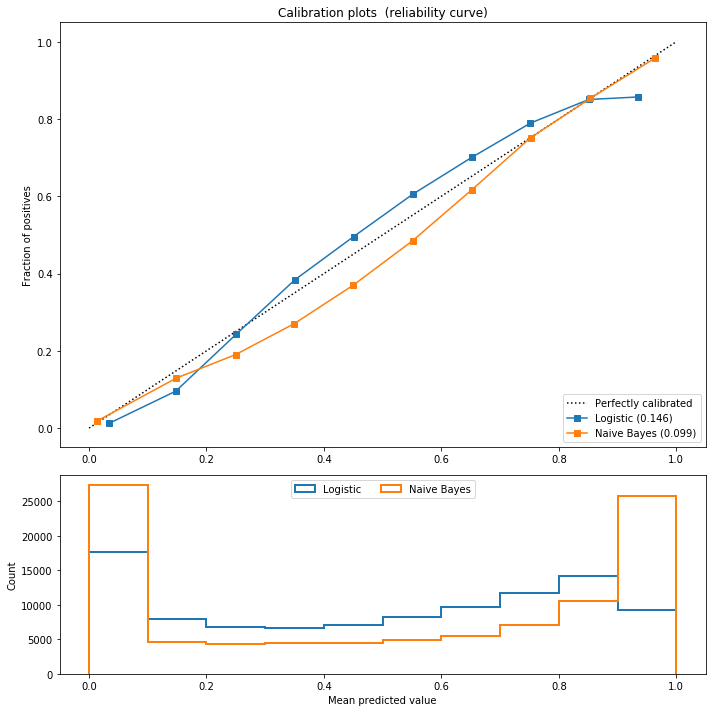

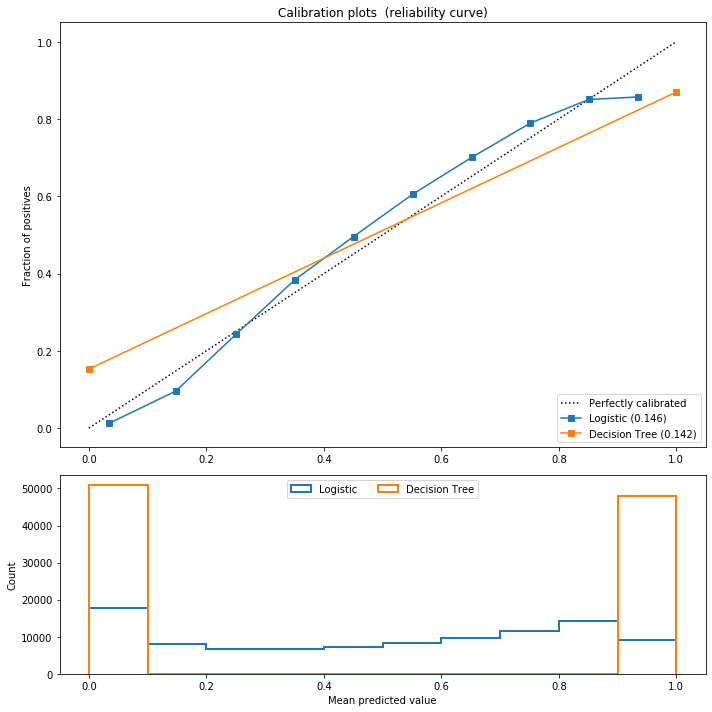

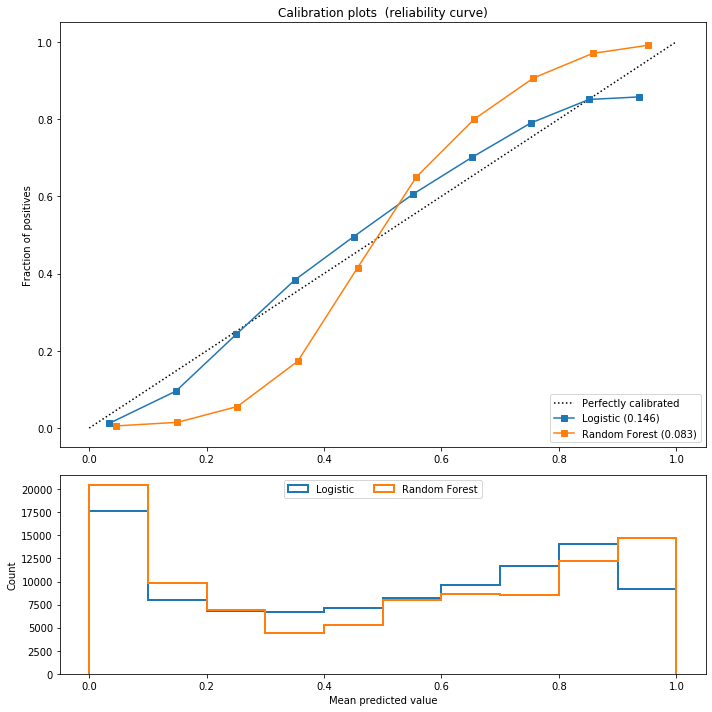

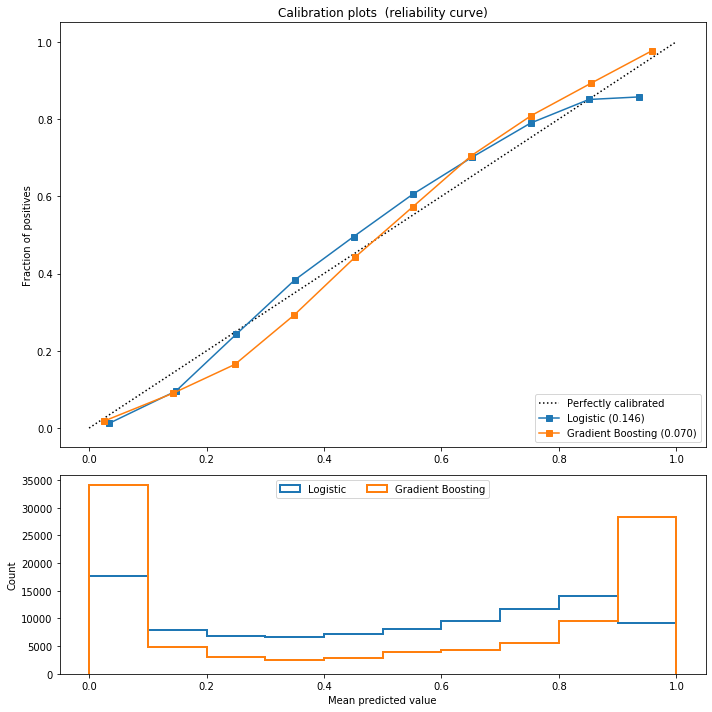

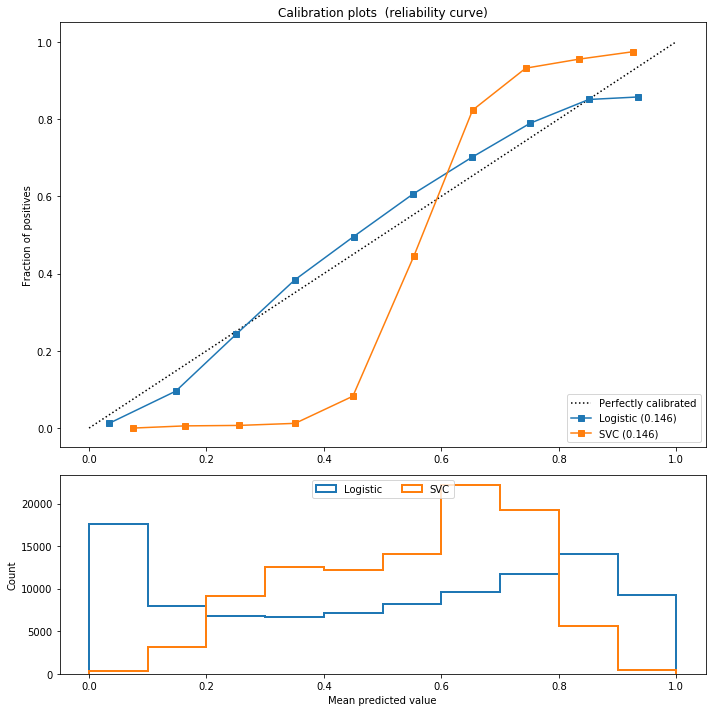

In [44]:
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)
plot_calibration_curve(DecisionTreeClassifier(max_depth=None), "Decision Tree", 2)
plot_calibration_curve(RandomForestClassifier(), "Random Forest", 3)
plot_calibration_curve(GradientBoostingClassifier(), "Gradient Boosting", 4)
plot_calibration_curve(SVC(), "SVC", 5)

## Why are some classification models miscalibrated?
- Logistic regression
    - Typically, produces well-calibrated models. This is because LR is trained by finding the parameters such that the 𝑋𝑡(𝑝−𝑦)=0 where p is the sigmoid function and X is the matrix of features and observations.
    - This formula can be reformulated as Σp = Σy. Thus, if there are 40 positive cases out of 100, then Σy = 40 and Σp = 100 * 0.4 = 40
- Naive Bayes
    - Tends to push predicted probabilities close to 0 or 1
    - Naive bayes assumes that features contribute indepdently to the probability predictions.
    - ??? Intuitively, why does this result in predicted probabilities clost to 0 and 1 ???
- Decision Tree
    - Without pruning (max_depth == None), the decision tree expands until leaf nodes only have one record: it is either 1 or 0. But because the tree is not perfect, it gets some of these predictions wrong. Thus, we see among all those classified as 0 by the tree, around .18 of them are actually a 1. Similarly, among those classified as 1, only 90% of them are actually 1s.
- Random forest (RF)
    - Pushes predicted probabilities away from 0 and 1 (towards the middle, or average) because the prediction is an average of a large collection of base-models, each of which sees only a small subset of the training data
    - If for a given case the prediction should be p = 0, then all the base-level models should predict 0. But this is unlikely to happen since each base-level model only sees a subset of the training dataset. We expect a high amount of variability across the predictions of the base-models. [Source](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf)
    - This can be seen in the calibration curve where in cases where the true frequency is low, the RF predicts a higher probability and, conversely, when the true frequency is high, RF predicts a lower probability.
- Gradient Boosting
- SVC

## How do you calibrate model predictions?

Two approaches:
1. Platt Scaling (single feature logistic regression)
2. Isotonic regression

Random Forest | Brier: 0.084 Precision: 0.889 Recall: 0.926 F1: 0.907



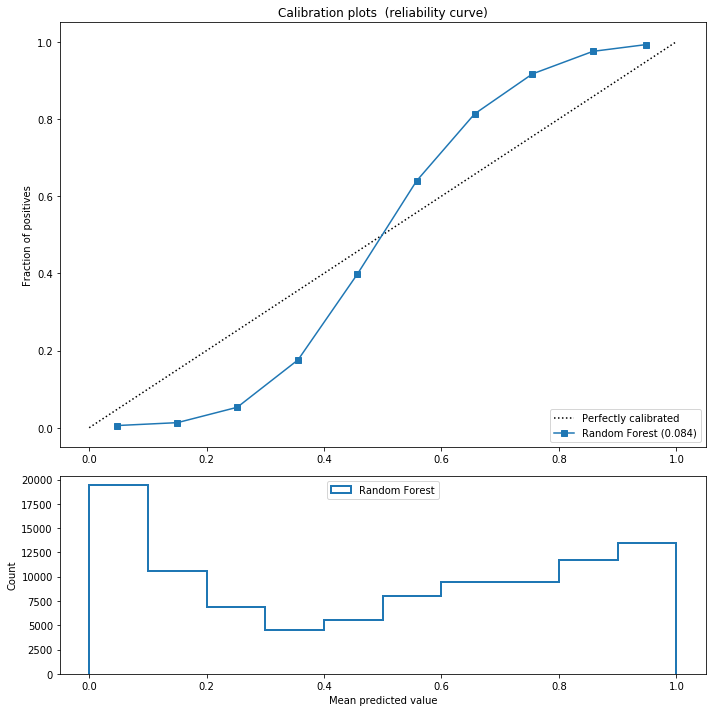

In [37]:
plot_calibration_curve(RandomForestClassifier(), "Random Forest", 3, with_logistic=False)

Steps to train and calibrate a model using k-fold CV:

1. For each split, fit model and generate prediction on validation set
2. Fit calibration model (say Platt scaling) using the predicted probabilities from the validation set
3. Store both the original model and the calibrated model
4. For prediction on new dataset, use calibrated models from each fold, generate prediction, then take the average across the folds

This algorithm is already implemented in the [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html) class in scikit-learn.

Note the importance of using a validation set to calibrated the model. If you use the same training data to calibrate the model, the calibration function makes the original model's output even more confident. In the extreme, if you keep fitting to the calibrated model to the same data, it will just predict 1 and 0.

In [13]:
def plot_calibration_curve_2(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """

    ###############################################################
    #              Probability calibration with CV
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')
    ###############################################################

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        model_plotter(clf, name, ax1, ax2)


    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Logistic | Brier: 0.146 Precision: 0.773 Recall: 0.824 F1: 0.798

Random Forest | Brier: 0.082 Precision: 0.892 Recall: 0.927 F1: 0.909

Random Forest + Isotonic | Brier: 0.076 Precision: 0.869 Recall: 0.931 F1: 0.899

Random Forest + Sigmoid | Brier: 0.076 Precision: 0.884 Recall: 0.911 F1: 0.897



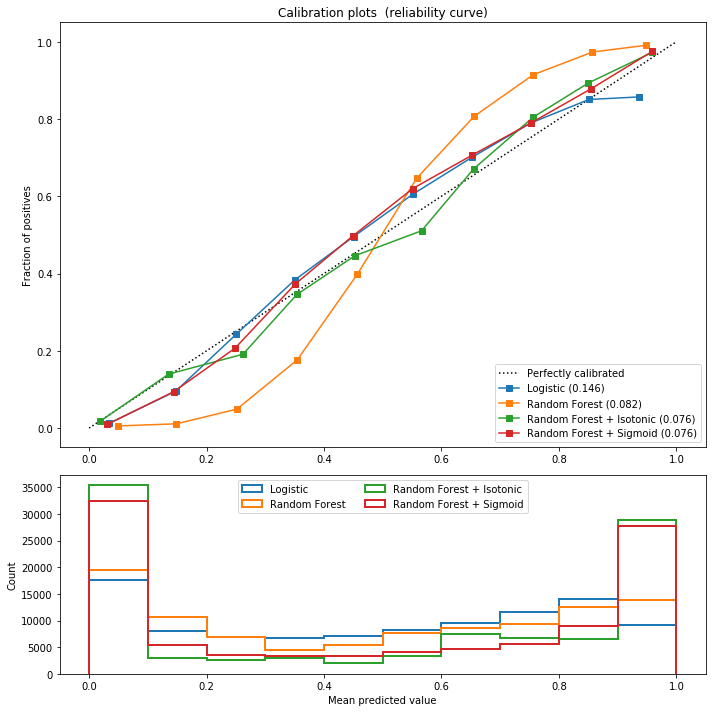

In [16]:
# plot_calibration_curve_2(GaussianNB(), "Naive Bayes", 1)
# plot_calibration_curve_2(DecisionTreeClassifier(), "Decision Tree", 2)
plot_calibration_curve_2(RandomForestClassifier(), "Random Forest", 3)
# plot_calibration_curve_2(GradientBoostingClassifier(), "Gradient Boosting", 4)
# plot_calibration_curve_2(SVC(), "SVC", 5)

# Summary

* For most classification models, the probability outputs do not reflect actual frequenc of outcomes
* The extent of such miscalibration can be evaluated using "Calibration plots" (also called reliability plots)
    * These plots bins the model's predictions and plots them against the true frequency observed
* If you only care about ranking your data by the model's predictions, you don't need to calibrate the model's output
* If, however, you want to interpret the predictions as probabilities (to calculate expected values, for example). Then for certain models (e.g. RF, Naive Bayes, Gradient Boosting), you should calibrate the predictions.
* Calibration can be done (for models with scikit-learn APIs) using [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html) with either Platt Scaling or Isotonic regression (depending on model being calibrated)